In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


def trend(time, slope=0):
    return slope * time


def sessional_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * sessional_pattern(season_time)


def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


time = np.arange(4 * 365 + 1)
baseline = 10
series = baseline + trend(time, 0.1)

amplitude = 40
series = seasonality(time, period=365, amplitude=amplitude)

slope = 0.05
series = baseline + trend(time, slope) + \
    seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

In [3]:
def window_dataset(series, window_size, batch_size=32, shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    # shift=1 for stateless RNN
    dataset = dataset.window(
        window_size + 1, shift=window_size, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
    # prefetch(1) for performance, batch(batch_size) for stateless RNN
    dataset = dataset.batch(1).prefetch(1)
    return dataset

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [5]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()


reset_states = ResetStatesCallback()

In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
batch_size = 128
train_set = window_dataset(x_train, window_size, batch_size=batch_size)
valid_set = window_dataset(x_valid, window_size, batch_size=batch_size)

model = keras.models.Sequential([
    keras.layers.Conv1D(32, kernel_size=5, padding="causal",
                                    activation="relu",
                                    input_shape=[None, 1]),
    keras.layers.LSTM(100, return_sequences=True,
                      dropout=0.2, recurrent_dropout=0.2,),  # batch_input_shape for stateful RNN
    keras.layers.LSTM(100, return_sequences=True,
                      dropout=0.2, recurrent_dropout=0.2),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
early_stopping = keras.callbacks.EarlyStopping(patience=10)
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)

history = model.fit(train_set, epochs=100,
                    validation_data=valid_set,
                    callbacks=[lr_schedule, early_stopping, model_checkpoint, reset_states])

Epoch 1/100



33/33 [==============================] - 18s 164ms/step - loss: 31.5980 - mae: 32.0943 - val_loss: 57.4478 - val_mae: 57.9478 - lr: 1.0000e-06
Epoch 2/100


C:\Users\STA Laptop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 4s 112ms/step - loss: 25.7557 - mae: 26.2512 - val_loss: 17.3097 - val_mae: 17.8038 - lr: 1.0798e-06
Epoch 3/100
33/33 [==============================] - 4s 106ms/step - loss: 19.7830 - mae: 20.2764 - val_loss: 28.9467 - val_mae: 29.4465 - lr: 1.1659e-06
Epoch 4/100
33/33 [==============================] - 4s 118ms/step - loss: 18.8380 - mae: 19.3308 - val_loss: 31.8164 - val_mae: 32.3149 - lr: 1.2589e-06
Epoch 5/100
33/33 [==============================] - 4s 110ms/step - loss: 18.7781 - mae: 19.2723 - val_loss: 19.8763 - val_mae: 20.3762 - lr: 1.3594e-06
Epoch 6/100
33/33 [==============================] - 4s 112ms/step - loss: 20.7022 - mae: 21.1968 - val_loss: 17.8176 - val_mae: 18.3146 - lr: 1.4678e-06
Epoch 7/100
33/33 [==============================] - 4s 116ms/step - loss: 17.2170 - mae: 17.7126 - val_loss: 22.7605 - val_mae: 23.2592 - lr: 1.5849e-06
Epoch 8/100
33/33 [==============================] - 4s 106ms/step - loss: 17.2651 - mae

(1e-06, 0.001, 0.0, 30.0)

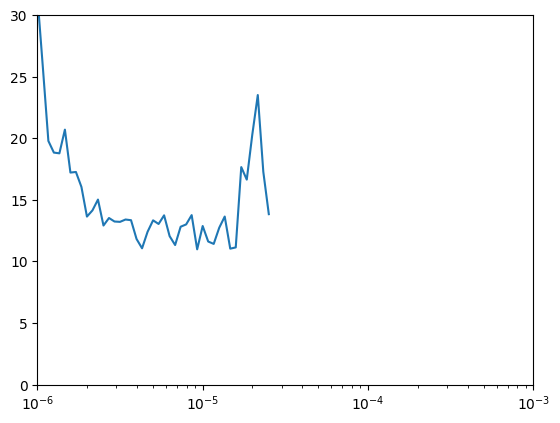

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 30])